In [95]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import more_itertools
import random
from torchmetrics import Accuracy
from sklearn.metrics.pairwise import cosine_similarity

# Tokenisation-related libraries
import re
from typing import Union, List
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Import custom modules
import dataset
from helpers import preprocess_text, create_skipgram_pairs, evaluate_accuracy, summarise_dataset, plot_loss, get_nearest_neighbors, get_random_sample, get_word_indices 
from model import Word2Vec
from train import train_word2vec
from helpers import get_nearest_neighbors

# Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

# Setup random seed
RANDOM_SEED = 42

In [82]:
# Ensures that modules are reloaded when the notebook is run

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
text8_data = dataset.import_text8_dataset()

# Print first few characters to verify
print("First 100 characters:")
print(text8_data[:1000])

# Print total length
print(f"\nTotal characters: {len(text8_data)}")

# Get initial word count (simple split)
initial_words = text8_data.split()
characters = len(text8_data) / 100
print(f"\nTotal words (raw split): {len(initial_words)}")
print(f"Initial vocabulary size: {len(set(initial_words))}")

First 100 characters:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coerc

In [84]:
# Set input 
input = text8_data[:10000]

# Process text inputs, receive tokens and word to index dictionary
processed_words, word_to_idx = preprocess_text(input, min_freq=5)

# Set vocab_size, determine dimensions of layers in model
vocab_size = len(word_to_idx)

# Set context length
context_len = 3

# Create Skip-gram dataset using processed, tokenized text input:
input_indices, context_indices = create_skipgram_pairs(processed_words, word_to_idx, context_len)

# Convert dataset indices to tensors
X = torch.tensor(input_indices, dtype=torch.long)
Y = torch.tensor(context_indices, dtype=torch.long)

# Debug prints
print("Vocabulary size:", len(word_to_idx))
print("Original text vocabulary size:", len(input.split()))
print("Dataset size:", len(input_indices))
print("Sample from vocabulary:", list(word_to_idx.keys())[:10])
print("Sample from processed words:", processed_words[:10])
print("X shape: ", X.shape, "; Y shape: ", Y.shape, "; Shapes compatible: ", X.shape[0] == Y.shape[0])

Vocabulary size: 65
Original text vocabulary size: 1603
Dataset size: 822
Sample from vocabulary: ['anarchism', 'a', 'term', 'of', 'first', 'including', 'the', 'revolution', 'and', 'is']
Sample from processed words: ['anarchism', 'a', 'a', 'term', 'of', 'first', 'including', 'the', 'of', 'the']
X shape:  torch.Size([822]) ; Y shape:  torch.Size([822, 2]) ; Shapes compatible:  True


In [85]:
# Set embedding dimensions
emb_dims = 20

# Instantiate word2vec model
word2vec = Word2Vec(vocab_size, emb_dims)

# Set up optimizer to optimize model's parameters
optimiser = torch.optim.SGD(params= word2vec.parameters(), lr = 0.1)


In [86]:
# After creating the dataset
summarise_dataset(X, Y, vocab_size)

Dataset size: 822
Vocabulary size: 65
Max index in X: 64
Max index in Y: 64
Sample X values: tensor([1, 1, 2, 3, 4, 5, 6, 3, 6, 7])
Sample Y values: tensor([[0, 1],
        [1, 2],
        [1, 3],
        [2, 4],
        [3, 5],
        [4, 6],
        [5, 3],
        [6, 6],
        [3, 7],
        [6, 8]])


In [87]:
lossi = train_word2vec(word2vec, X, Y, vocab_size, optimiser, context_len, device, batch_size=8, epochs=100)

Training for 100 epochs with batch size 8, batches: 102
Batch shapes - X: torch.Size([8]), Pos: torch.Size([8, 2]), Neg: torch.Size([8, 2])
Max indices - X: 43, Pos: 61, Neg: 61
Vocab size: 65
Epoch 1 | Batch 1 | Loss: 1.41628 | Accuracy: 0.5134
Epoch 1 | Batch 21 | Loss: 1.27742 | Accuracy: 0.5134
Epoch 1 | Batch 41 | Loss: 1.52764 | Accuracy: 0.5408
Epoch 1 | Batch 61 | Loss: 1.36751 | Accuracy: 0.5645
Epoch 1 | Batch 81 | Loss: 1.50702 | Accuracy: 0.5791
Epoch 1 | Batch 101 | Loss: 1.28500 | Accuracy: 0.5809
Batch shapes - X: torch.Size([8]), Pos: torch.Size([8, 2]), Neg: torch.Size([8, 2])
Max indices - X: 47, Pos: 56, Neg: 58
Vocab size: 65
Epoch 2 | Batch 1 | Loss: 1.30375 | Accuracy: 0.5809
Epoch 2 | Batch 21 | Loss: 1.28796 | Accuracy: 0.6083
Epoch 2 | Batch 41 | Loss: 1.33006 | Accuracy: 0.5961
Epoch 2 | Batch 61 | Loss: 1.42345 | Accuracy: 0.6095
Epoch 2 | Batch 81 | Loss: 1.35486 | Accuracy: 0.6277
Epoch 2 | Batch 101 | Loss: 1.33394 | Accuracy: 0.6229
Batch shapes - X: torc

In [88]:
print(lossi)

[1.4162797927856445, 1.583827018737793, 1.3822040557861328, 1.4185097217559814, 1.4236869812011719, 1.3176028728485107, 1.4973945617675781, 1.525059700012207, 1.5015122890472412, 1.43264901638031, 1.6632189750671387, 1.7059710025787354, 1.5922293663024902, 1.5819079875946045, 1.4061517715454102, 1.3321791887283325, 1.4005247354507446, 1.2160968780517578, 1.5819859504699707, 1.4700803756713867, 1.2774178981781006, 1.480654001235962, 1.4101554155349731, 1.5415489673614502, 1.580216646194458, 1.5475869178771973, 1.4174319505691528, 1.432203769683838, 1.5764720439910889, 1.3036112785339355, 1.5161423683166504, 1.5293117761611938, 1.603153944015503, 1.3007984161376953, 1.4142930507659912, 1.4242098331451416, 1.318363070487976, 1.4587244987487793, 1.5743587017059326, 1.378054141998291, 1.5276418924331665, 1.4802155494689941, 1.4440486431121826, 1.4253871440887451, 1.380844235420227, 1.3978359699249268, 1.679237961769104, 1.3202145099639893, 1.5267724990844727, 1.5587295293807983, 1.492113232

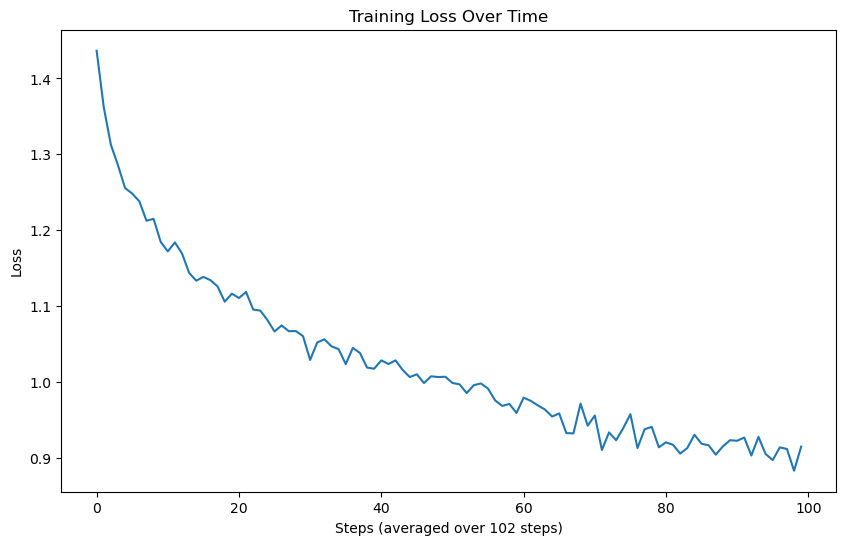

In [89]:
plot_loss(lossi)

In [90]:
# Example usage
word = "anarchism"
nearest_neighbors = get_nearest_neighbors(word, word_to_idx, word2vec.embeddings.weight, n=5)


The nearest neighbours of  anarchism  are:  [('it', 0.5592113), ('first', 0.44114584), ('for', 0.42686093), ('some', 0.40488687), ('an', 0.4038341)]


In [94]:
random_sample = get_random_sample(processed_words, n=20)

Random sample of words:
['society', 'movement', 'with', 'what', 'to', 'self', 'to', 'by', 'the', 'in', 'called', 'and', 'to', 'in', 'including', 'in', 's', 'to', 'of', 'the']
